In [175]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,InputLayer,Convolution1D,MaxPooling1D,BatchNormalization,Concatenate,Input

seq_len, filter_len = 118, 8
# seq_len, filter_len = 118, 12
# nbr_filters, nodes = 100, 300
# dropout = (0.2, 0)
# # dropout = (0, 0)
# layers, border_mode = 2 , 'same'

nbr_filters, nodes = 100, 200
dropout = (0.15, 0.15)
# dropout = (0, 0)
layers, border_mode = 2 , 'same'

''' Build model archicture and fit.'''
model = Sequential()
if layers >= 1:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
if layers >= 2:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
if layers >= 3:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
model.add(Flatten())

model.add(Dense(nodes,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))

model.add(Dense(1,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('linear'))
model.summary()

#compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-06)
model.compile(loss="mean_squared_error", optimizer=adam)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)              │ (None, 118, 100)       │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 118, 100)       │        80,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 118, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 11800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 200)            │     2,360,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,443,801 (9.32 MB)

 Trainable params: 2,443,801 (9.32 MB)

 Non-trainable params: 0 (0.00 B)

In [176]:
import os
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors


set_seed(42)
# name="pl3-1-2"
# datadir=f"/data/home/jinyalong/data/sev_240624/results/{name}/{name}_"
name="pl4-3-2"
datadir=f"/data/home/jinyalong/data/sev_240707/results/{name}/{name}_"
# datadir="./data"
e_train = pd.read_csv(f"{datadir}train.csv")
e_test= pd.read_csv(f"{datadir}test.csv")
print(e_train.shape, e_test.shape)

seq_e_train = one_hot_encode(e_train,seq_len=seq_len)
seq_e_test = one_hot_encode(e_test, seq_len=seq_len)
label = 'score' # abs_score:0.2987 0.6760
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, mode='min', verbose=1, 
                          restore_best_weights = True)
history = model.fit(seq_e_train, e_train['scaled_rl'], batch_size=64, epochs=15,callbacks=[earlyStop], verbose=1,
                    validation_data=(seq_e_test,e_test["scaled_rl"]), shuffle=True)


(2818, 8) (149, 8)
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6046 - val_loss: 0.9698
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8986 - val_loss: 0.7553
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7473 - val_loss: 0.6915
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6612 - val_loss: 0.6730
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6508 - val_loss: 0.6628
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6470 - val_loss: 0.6822
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6376 - val_loss: 0.6591
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6356 - val_loss: 0.6710
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6167 - val_loss: 0.6783
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6258 - val_loss: 0.6743
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6049 - val_loss: 0.6851
Epoch 11: early stopping
Restoring model wei

In [177]:
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

e_test = test_data(df=e_test, model=model, obs_col=label,test_seq=seq_e_test)
r = r2(e_test[label], e_test['pred'])
pr =  stats.pearsonr(e_test[label], e_test['pred'])
print('test r-squared = ', r, "pearsonR = ", pr[0])
e_train = test_data(df=e_train, model=model, obs_col=label,test_seq=seq_e_train)
r = r2(e_train[label], e_train['pred'])
pr =  stats.pearsonr(e_train[label], e_train['pred'])
print('train r-squared = ', r, "pearsonR = ", pr[0])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
test r-squared =  0.34388115436774463 pearsonR =  0.5864138081318896
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
train r-squared =  0.41512799309502935 pearsonR =  0.6443042705857452


In [95]:
data_dir="/data/home/jinyalong/data/sev_240624"
dna_df = pd.read_csv(f"{data_dir}/DNA1_raw_clean.csv")
dna_df["rate"] = dna_df["dismatch"]/dna_df["plasmid_counts"]
dna_df.index=dna_df["seq"]
rmap = dna_df.to_dict("dict")["rate"]
e_test["bias"]=e_test.apply(lambda x:abs(x["score"]-x["pred"]),axis=1)
e_test["rate"]=e_test["seq"].map(rmap)
e_test

,Unnamed: 0,seq,rna_counts,plasmid_counts,abs_score,score,length,ttype,scaled_rl,pred,bias,rate
0,0,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGGCCCAG...,2440,591,4.128596,-0.356228,118,True,0.099218,1.143498,1.499725,0.015267
1,1,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,49,1939,0.025271,-5.452272,118,True,-1.651430,-2.406745,3.045528,0.024953
2,2,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGATACCCAA...,3992,35,114.057143,2.962534,118,True,1.239315,0.937297,2.025237,0.050661
3,3,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGAGCCAA...,3287,547,6.009141,0.019117,118,True,0.228161,1.068627,1.049511,0.030792
4,4,ATCCCGGGCGAGGCAACCCAGCATCCTCAGTCACAGAAAGATCCAA...,796,384,2.072917,-1.045208,118,True,-0.137468,0.895740,1.940949,0.022196
...,...,...,...,...,...,...,...,...,...,...,...,...
234,234,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,5509,95,57.989474,2.286096,118,True,1.006938,1.123397,1.162700,0.033003
235,235,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGAACCAA...,13045,1171,11.140051,0.636382,118,True,0.440210,1.153293,0.516912,0.033890
236,236,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,1,15,0.066667,-4.482215,118,True,-1.318185,-4.510572,0.028357,0.019324
237,237,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,1167,223,5.233184,-0.119145,118,True,0.180663,1.113102,1.232247,0.002058


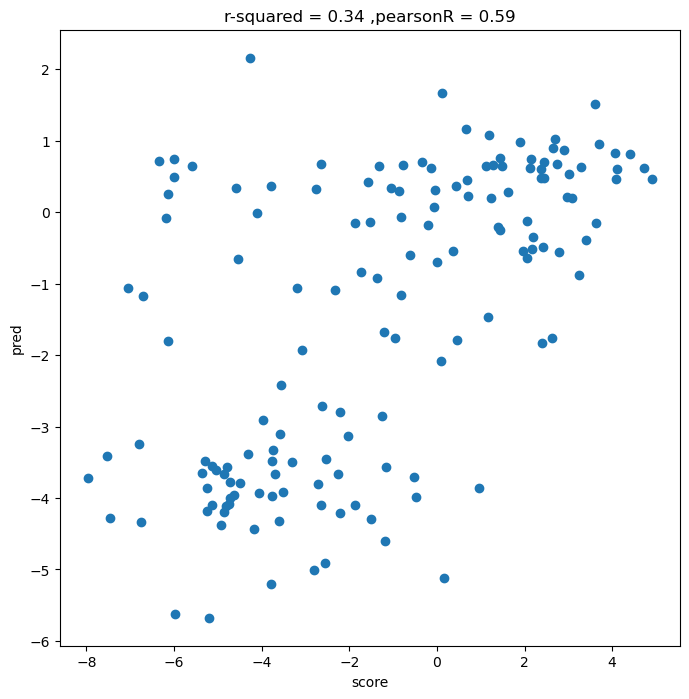

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

# data_dir="/data/home/jinyalong/data/sev_240707/results"
# dna_df = pd.read_csv(f"{data_dir}/pl4-2-N-2/pl4-2-N-2_final.csv")
data_dir="/data/home/jinyalong/data/sev_240624/results"
dna_df = pd.read_csv(f"{data_dir}/pl3-2-2/pl3-2-2_final.csv")
seqs8=set(dna_df["seq"].values)
e_test["isin_8day"]=e_test["seq"].apply(lambda x:x in seqs8)
e_test_in = e_test[e_test["isin_8day"]]
e_test_notin = e_test[~e_test["isin_8day"]]

sdf = e_test
# target,pred = "bias","rate"
target,pred = "score","pred"
r = r2(sdf[target],sdf[pred])
pr =  stats.pearsonr(sdf[target],sdf[pred])
plt.figure(figsize=(8, 8))
plt.title(f"r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
plt.scatter(sdf[target], sdf[pred], marker='o')
# plt.scatter(e_test_in[target], e_test_in[pred], marker='o')
# plt.scatter(e_test_notin[target], e_test_notin[pred], marker='x')
plt.xlabel(target)
plt.ylabel(pred)
plt.show()

# e_test[e_test["rate"]==0]

# scaler = preprocessing.StandardScaler()
# scaler.fit(e_test["score"].values.reshape(-1,1))
# scaler.inverse_transform(np.array([[1.469156]]))

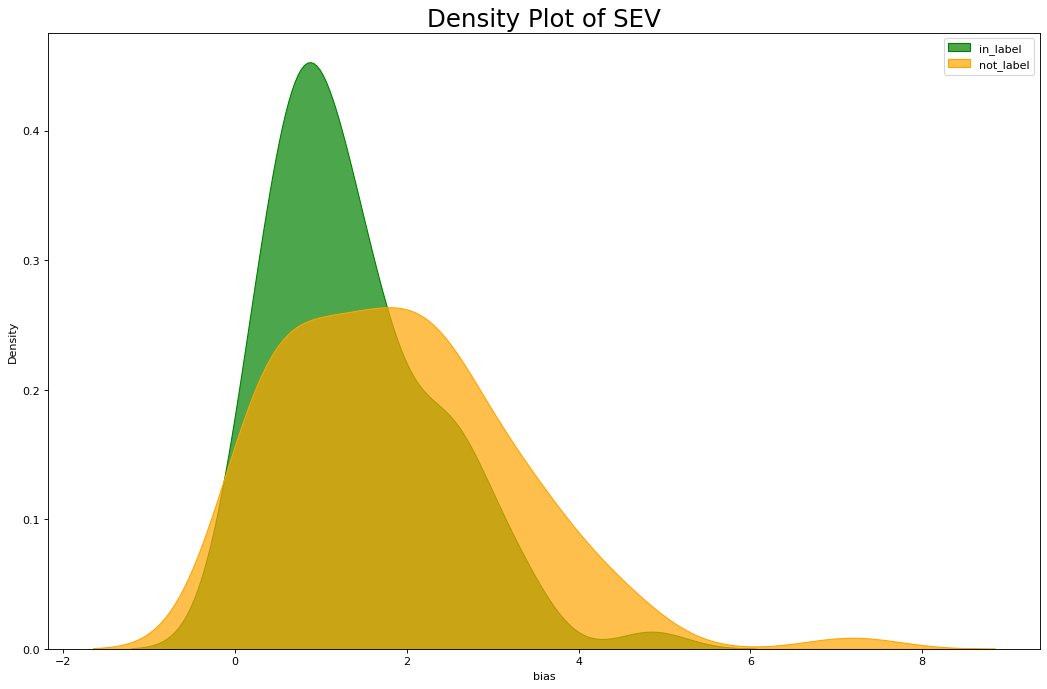

In [115]:
data_dir="/data/home/jinyalong/data/sev_240624/results"
# dna_df = pd.read_csv(f"{data_dir}/pl3-2-2/pl3-2-2_final.csv")
dna_df = pd.read_csv(f"{data_dir}/pl3-2-2/pl3-2-2_final.csv")
seqs8=set(dna_df["seq"].values)
e_test["bias"]=e_test.apply(lambda x:abs(x["score"]-x["pred"]),axis=1)
e_test["isin_8day"]=e_test["seq"].apply(lambda x:x in seqs8)
label = "bias" # abs_score,length, score
e_test_in = e_test[e_test["isin_8day"]]
e_test_notin = e_test[~e_test["isin_8day"]]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(e_test_in[label], shade=True, color="g", label="in_label", alpha=.7)
sns.kdeplot(e_test_notin[label], shade=True, color="orange", label="not_label", alpha=.7) 
# sns.kdeplot(e_train['score'], shade=True, color="black", label="train_label", alpha=.7)
# sns.kdeplot(e_test['pred'], shade=True, color="dodgerblue", label="test_pred", alpha=.7)

# Decoration
plt.title('Density Plot of SEV', fontsize=22)
plt.legend()
plt.show()

In [116]:
sdf = e_test_in
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
r, pr

(0.6985810459001172,
 PearsonRResult(statistic=0.8358116090962824, pvalue=1.0812939807984676e-20))

In [117]:
sdf = e_test_notin
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
r, pr

(0.5864495875548797,
 PearsonRResult(statistic=0.7657999657579513, pvalue=1.3784010730496544e-17))

In [118]:
e_test_notin.shape,e_test_in.shape

((85, 12), (75, 12))

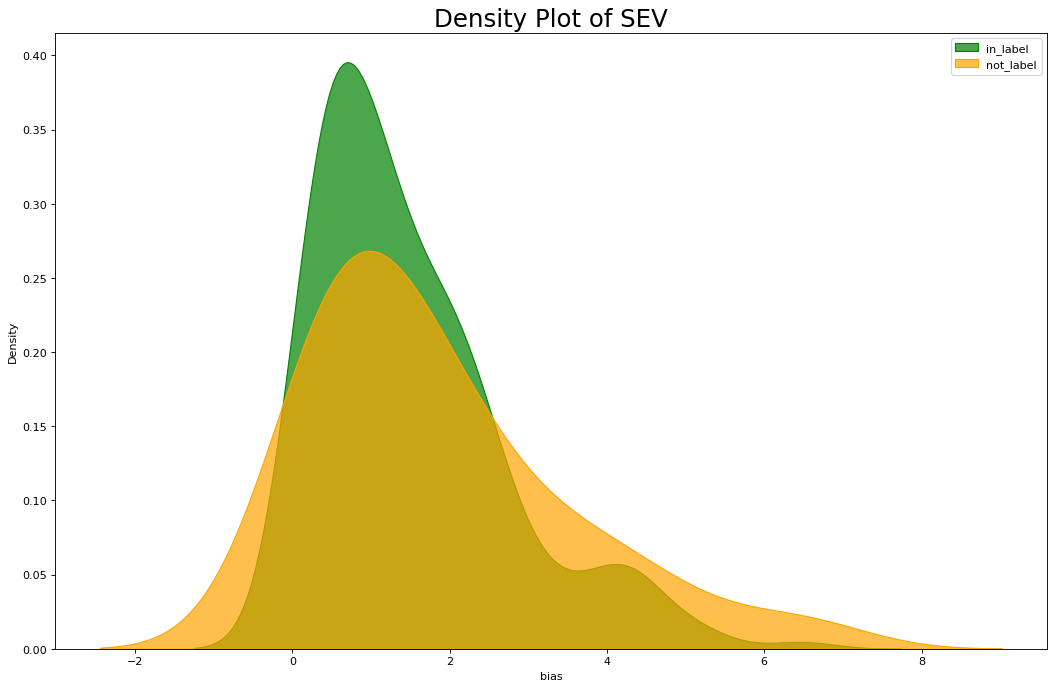

In [108]:
data_dir="/data/home/jinyalong/data/sev_240707/results"
name = "pl4-2-N-2"
dna_df = pd.read_csv(f"{data_dir}/{name}/{name}_final.csv")
seqs8=set(dna_df["seq"].values)
e_test["bias"]=e_test.apply(lambda x:abs(x["score"]-x["pred"]),axis=1)
e_test["isin_8day"]=e_test["seq"].apply(lambda x:x in seqs8)
label = "bias" # abs_score,length, score
e_test_in = e_test[e_test["isin_8day"]]
e_test_notin = e_test[~e_test["isin_8day"]]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(e_test_in[label], shade=True, color="g", label="in_label", alpha=.7)
sns.kdeplot(e_test_notin[label], shade=True, color="orange", label="not_label", alpha=.7) 
# sns.kdeplot(e_train['score'], shade=True, color="black", label="train_label", alpha=.7)
# sns.kdeplot(e_test['pred'], shade=True, color="dodgerblue", label="test_pred", alpha=.7)

# Decoration
plt.title('Density Plot of SEV', fontsize=22)
plt.legend()
plt.show()

In [109]:
sdf = e_test_in
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
r, pr

(0.5334650707811802,
 PearsonRResult(statistic=0.7303869322360446, pvalue=8.734645216894011e-37))

In [110]:
sdf = e_test_notin
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
r, pr

(0.41707938912105297,
 PearsonRResult(statistic=0.6458168386787797, pvalue=0.00036604683380660164))

In [111]:
e_test_notin.shape,e_test_in.shape

((26, 12), (213, 12))

In [152]:
model.save("./models/pl5-1-1.keras")